In [40]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
import random
# Visualization with t-SNE
from sklearn.manifold import TSNE

In [41]:
words = open('names.txt', 'r').read().splitlines()
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [42]:
# build the dataset
block_size = 4 # context length: how many characters do we take to predict the next one?

@torch.no_grad() # do not calculate graph and gradient for function output
def build_dataset(words):  
  X, Y = [], []
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words)) # 80 percent of data
n2 = int(0.9*len(words)) # 90 percent of data

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182625, 4]) torch.Size([182625])
torch.Size([22655, 4]) torch.Size([22655])
torch.Size([22866, 4]) torch.Size([22866])


In [43]:
# reset parameters to be able to start training from scratch 
def initialize():
    global C, W1, b1, W2, b2, parameters # these variables should be global to be modified outside the function's scope
    g = torch.Generator().manual_seed(2147483647) # for reproducibility
    C = torch.randn((27, 60), generator=g) # represent each of the chars(27 in total) as 2 dimensional embedding vector 
    W1 = torch.randn((240, 400), generator=g) # first layer gets 4 chars as 2 dimensional vectors each => 4*2 = 8 dimensional 
    b1 = torch.randn(400, generator=g) # biases for each of the 300 neurons of the layer 
    # make logits smaller to get unoformly distributed next characters predictions at initialization ie first run of optimization 
    # for that, multiply initialization parameters with small numbers 
    W2 = torch.randn((400, 27), generator=g) * 0.01 # weights shoud not be initialized with 0s 
    b2 = torch.randn(27, generator=g) * 0
    parameters = [C, W1, b1, W2, b2]
    for p in parameters:
        p.requires_grad = True # calculate graph and gradient for parameters


In [44]:
# train model on training set (90 percent of data) in minibatches to speed up the process and evaluate on validation set
# when loss on training set is much lower then on val set => model overfitting on training data achieved 
def train_model(minibatch_size, n=20000):
    initialize()
    # Create lists for this specific run
    current_train_loss = []
    current_val_loss = []
    current_steps = []
    
    for i in range(n):
        # minibatch construct
        ix = torch.randint(0, Xtr.shape[0], (minibatch_size,))
        
        # forward pass
        emb = C[Xtr[ix]] 
        h = torch.tanh(emb.view(-1, 240) @ W1 + b1)  
        logits = h @ W2 + b2  
        loss = F.cross_entropy(logits, Ytr[ix])
        
        # backward pass
        for p in parameters:
            p.grad = None
        loss.backward()
    
        # update
        lr = 0.1 if i < 19000 else 0.01
        for p in parameters:
            p.data += -lr * p.grad

        # calculate losses on full datasets for comparison periodically
        if i % 100 == 0 :
            with torch.no_grad():
                # full training set loss
                train_emb = C[Xtr]
                train_h = torch.tanh(train_emb.view(-1, 240) @ W1 + b1)
                train_logits = train_h @ W2 + b2
                train_loss = F.cross_entropy(train_logits, Ytr)
                
                # full dev set loss
                dev_emb = C[Xdev]
                dev_h = torch.tanh(dev_emb.view(-1, 240) @ W1 + b1)
                dev_logits = dev_h @ W2 + b2  
                dev_loss = F.cross_entropy(dev_logits, Ydev)

            
                # track stats for this run
                current_steps.append(i)
                current_train_loss.append(train_loss.item())
                current_val_loss.append(dev_loss.item())
    
    return current_steps, current_train_loss, current_val_loss


2.112334966659546 1024


<Figure size 1000x600 with 0 Axes>

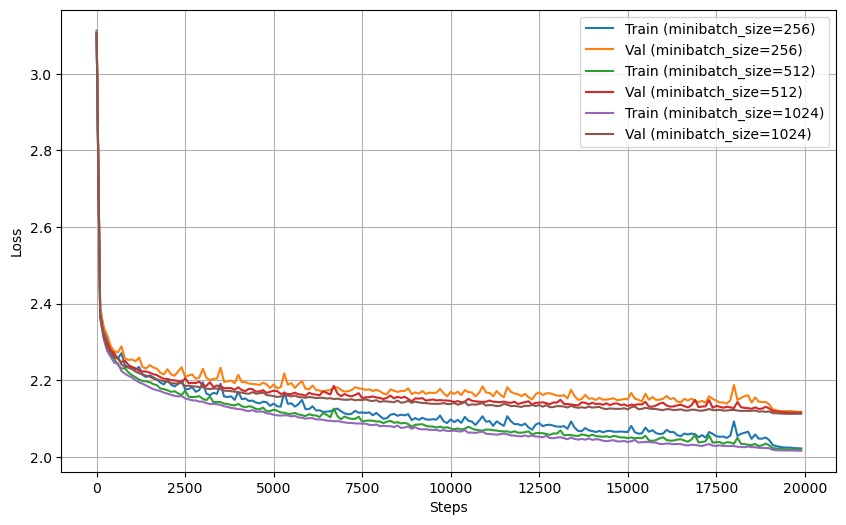

In [27]:
hyperparams = {
    'minibatch_size': [256, 512, 1024]
}

best_val_loss = float('inf')  # Initialize best_val_loss
plt.figure(figsize=(10, 6))   

for m_size in hyperparams['minibatch_size']:
    stepi, train_losses, val_losses = train_model(m_size)
    plt.plot(stepi, train_losses, label=f'Train (minibatch_size={m_size})')
    plt.plot(stepi, val_losses, label=f'Val (minibatch_size={m_size})')
    
    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        best_batch_size = m_size
print(best_val_loss, best_batch_size)

plt.xlabel('Steps')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

Running PCA...
PCA done!


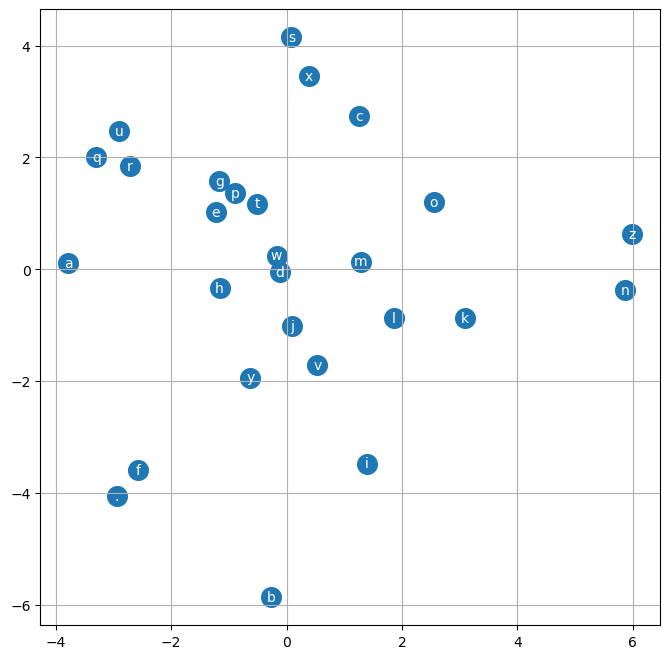

In [34]:
if C.shape[1] == 2: 
    plt.clf()  # Clear the current figure
    plt.close('all')  # Close all figures
    plt.figure(figsize=(8,8))
    
    x = C[:,0].detach().numpy()
    y = C[:,1].detach().numpy()
    plt.scatter(x, y, s=200)
    
    for i in range(C.shape[0]):
        plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
    plt.grid('minor')
    plt.savefig('character_embeddings.png')
    plt.show()
    
elif C.shape[1] == 60:
    plt.clf()
    plt.close('all')
    plt.figure(figsize=(8,8))
    embeddings = C.detach().numpy()
    print("Running PCA...")
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings)
    print("PCA done!")
    
    plt.scatter(embeddings_2d[:,0], embeddings_2d[:,1], s=200)
    for i in range(len(itos)):
        plt.text(embeddings_2d[i,0], embeddings_2d[i,1], itos[i], 
                ha="center", va="center", color='white')
    plt.savefig('character_embeddings.png')

    plt.grid('minor')
    plt.show()

In [36]:
# Evaluate on test set
with torch.no_grad():
    test_emb = C[Xte]
    test_h = torch.tanh(test_emb.view(-1, 240) @ W1 + b1)
    test_logits = test_h @ W2 + b2
    test_loss = F.cross_entropy(test_logits, Yte)
    
    
    # Calculate accuracy
    predictions = test_logits.argmax(dim=1)
    accuracy = (predictions == Yte).float().mean()
    print(accuracy)

tensor(0.3458)


In [39]:


# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

montaimyan.
seel.
ndylyah.
remman.
endrlen.
adelyn.
elie.
shyanea.
edennesor.
arleal.
kohlyan.
noshabergahimael.
kindr.
jennixg.
pacey.
brendel.
kylene.
eliylah.
myshaud.
ahman.
